<a href="https://colab.research.google.com/github/oscar-9/speech_emotion_project/blob/main/speech_emotion_recog_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup access to google drive

Accessing google drive where RAVDESS data is stored (sample rate already reduced. 24 actors x 60 clips = 1440 files total)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/speech_emotion_project/ravdess_data")

Mounted at /content/drive


Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa as libr
import soundfile as sf
import IPython.display as ipd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Exploring data:

Filename identifiers

1) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

2) Vocal channel (01 = speech, 02 = song).

3) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

4) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

5) Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

6) Repetition (01 = 1st repetition, 02 = 2nd repetition).

7) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

(From (https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio))



**"03-01-08-02-02-02-24" -> actor = 24, emotion = surprised, statement = "Dogs are sitting by the door"**

In [ ]:
# Checking number of files present =1440 as expected (24 actors x 60 clips)
ravdess_files = os.listdir("/content/drive/MyDrive/speech_emotion_project/ravdess_data")
print(len(ravdess_files))

1440


In [ ]:
# libr.load() gives a numpy array of the audio signals, and the sample rate (hertz, integer (samples per second))
test_path ="/content/drive/MyDrive/speech_emotion_project/ravdess_data/03-01-08-02-02-02-24.wav"
test_array1, test_sample_rate = libr.load(test_path)
print(test_array1)
print(len(test_array1))
print(test_sample_rate)

[0.         0.         0.         ... 0.00012757 0.00012075 0.        ]
80195
22050


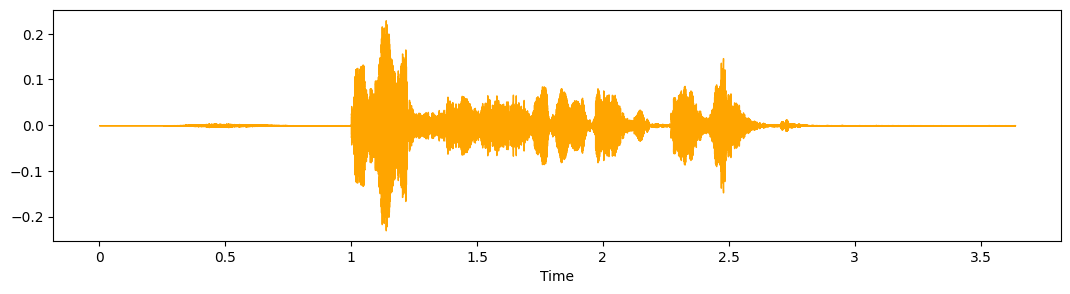

In [ ]:
# Displaying waveform
test_waveform = plt.figure(figsize=(13,3), facecolor=(1, 1, 1))
libr.display.waveshow(test_array1, sr=test_sample_rate, color='orange')
# Clip player
ipd.Audio(test_path)

# Loading data and feature extraction

In [ ]:
# Generating a list of file paths for all data
ravdess_location = "/content/drive/MyDrive/speech_emotion_project/ravdess_data/"
ravdess_files = glob(ravdess_location + '*.wav')

In [ ]:
# Defining functions
def load_audio_file(file):
  y, sr = libr.load(file, sr=None) # Using native sample rate
  return y, sr

def get_emotion(file): # Uses filename and naming scheme to determine emotion
  emotions_dict = {
      "01" : "Neutral",
      "02" : "Calm",
      "03" : "Happy",
      "04" : "Sad",
      "05" : "Angry",
      "06" : "Fearful",
      "07" : "Disgust",
      "08" : "Surprised"
  }
  emotion_descriptor = [emotions_dict.get(str(file[65:67]))]
  return emotion_descriptor

def y_sr_functs(y, sr): # Splitting functions up that need 1 or 2 pos. arguments
  y_sr_functs_list = [
      libr.feature.chroma_stft,
      libr.feature.mfcc,
      libr.feature.spectral_bandwidth,
      libr.feature.spectral_centroid,
      libr.feature.spectral_contrast,
      libr.feature.spectral_rolloff
  ]
  y_sr_features = [np.mean(funct(y=y, sr=sr)) for funct in y_sr_functs_list] # Taking the means for each function output to obtain 1 value per feature per sample for simplicity
  return y_sr_features

def y_functs(y):
  y_functs_list = [
      libr.feature.rms,
      libr.feature.spectral_flatness,
      libr.feature.zero_crossing_rate
  ]
  y_features = [np.mean(funct(y=y)) for funct in y_functs_list]
  return y_features

In [ ]:
# Loop to iterate functions for each audio file.
feature_extraction_output = []
for file in ravdess_files:
  y, sr = load_audio_file(file)
  emotion_descriptor = get_emotion(file)
  y_sr_features = y_sr_functs(y, sr)
  y_features = y_functs(y)
  full_output = emotion_descriptor + y_sr_features + y_features
  feature_extraction_output.append(full_output)
print(feature_extraction_output)
# Output is a list of lists containing the emotion
# and the mean feature values per audio file.

[['Calm', 0.49052778, -29.747, 2044.7517162108004, 1985.2822759978617, 17.364738507603604, 4445.097477064221, 0.0017676968, 0.019621884, 0.07726490825688073], ['Fearful', 0.4622605, -23.070072, 1703.0386936415869, 1719.3333838723172, 18.80479909605276, 3580.978260869565, 0.010192503, 0.03418205, 0.09107506793478261], ['Calm', 0.4765646, -30.18546, 2028.544971088683, 2030.085895726093, 17.51590089734757, 4424.011752136752, 0.0015284528, 0.036290813, 0.08204377003205128], ['Calm', 0.5127108, -30.052273, 2066.3009467037964, 2108.624148239504, 16.96983528650506, 4597.1086448598135, 0.0016400209, 0.03731501, 0.08889913113317757], ['Neutral', 0.50511175, -28.289143, 1996.858809908913, 1917.4453039129633, 17.228117968145316, 4291.903409090909, 0.002827845, 0.019509621, 0.07377485795454546], ['Angry', 0.48755303, -26.719353, 2032.8565241159406, 1960.1106297206486, 17.305986444238084, 4444.045608108108, 0.0071520363, 0.0245925, 0.08337292370495496], ['Happy', 0.4776594, -28.637089, 2017.9612662

In [ ]:
# Converting to dataframe
df = pd.DataFrame(feature_extraction_output, columns=["emotion","chroma_stft","MFCC","spec_bandwidth","spec_centroid","spec_contrast","roll_off_freq","RMS","spec_flatness","zero_crossing_rate"])
df.head()

,emotion,chroma_stft,MFCC,spec_bandwidth,spec_centroid,spec_contrast,roll_off_freq,RMS,spec_flatness,zero_crossing_rate
0,Calm,0.490528,-29.747000,2044.751716,1985.282276,17.364739,4445.097477,0.001768,0.019622,0.077265
1,Fearful,0.462261,-23.070072,1703.038694,1719.333384,18.804799,3580.978261,0.010193,0.034182,0.091075
2,Calm,0.476565,-30.185459,2028.544971,2030.085896,17.515901,4424.011752,0.001528,0.036291,0.082044
3,Calm,0.512711,-30.052273,2066.300947,2108.624148,16.969835,4597.108645,0.001640,0.037315,0.088899
4,Neutral,0.505112,-28.289143,1996.858810,1917.445304,17.228118,4291.903409,0.002828,0.019510,0.073775


In [ ]:
# Describing dataframe
print(df.shape)
print(f"\n")
print(df.info())
print(f"\n")
df['emotion'].value_counts()

(1440, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   emotion             1440 non-null   object 
 1   chroma_stft         1440 non-null   float32
 2   MFCC                1440 non-null   float32
 3   spec_bandwidth      1440 non-null   float64
 4   spec_centroid       1440 non-null   float64
 5   spec_contrast       1440 non-null   float64
 6   roll_off_freq       1440 non-null   float64
 7   RMS                 1440 non-null   float32
 8   spec_flatness       1440 non-null   float32
 9   zero_crossing_rate  1440 non-null   float64
dtypes: float32(4), float64(5), object(1)
memory usage: 90.1+ KB
None




Calm         192
Fearful      192
Angry        192
Happy        192
Surprised    192
Sad          192
Disgust      192
Neutral       96
Name: emotion, dtype: int64

In [ ]:
# Abandoned code
'''
df_2 = df




df_2['emotion'] = df_2['emotion'].map({
      "Neutral" : "01",
      "Calm" : "02",
      "Happy" : "03",
      "Sad" : "04",
      "Angry" : "05",
      "Fearful" : "06",
      "Disgust" : "07",
      "Surprised" : "08"
  }).astype(float)
df_2.head()
'''

# Pre-processing and training

In [ ]:
# New dataframe containing emotion only
X = df.drop('emotion', axis=1)
y = df['emotion']

print(X.head())
print(f"\n")
print(y.head())

   chroma_stft       MFCC  spec_bandwidth  spec_centroid  spec_contrast  \
0     0.490528 -29.747000     2044.751716    1985.282276      17.364739   
1     0.462261 -23.070072     1703.038694    1719.333384      18.804799   
2     0.476565 -30.185459     2028.544971    2030.085896      17.515901   
3     0.512711 -30.052273     2066.300947    2108.624148      16.969835   
4     0.505112 -28.289143     1996.858810    1917.445304      17.228118   

   roll_off_freq       RMS  spec_flatness  zero_crossing_rate  
0    4445.097477  0.001768       0.019622            0.077265  
1    3580.978261  0.010193       0.034182            0.091075  
2    4424.011752  0.001528       0.036291            0.082044  
3    4597.108645  0.001640       0.037315            0.088899  
4    4291.903409  0.002828       0.019510            0.073775  


0       Calm
1    Fearful
2       Calm
3       Calm
4    Neutral
Name: emotion, dtype: object


In [ ]:
# Splitting dataset: 80/20 split
training_X, test_X, training_y, test_y = train_test_split(X, y, test_size=0.2)

print(training_X.head())
print(f"\n")
print(training_y.head())
print(f"\n")
print(training_X.shape)
print(test_X.shape)
print(training_y.shape)
print(test_y.shape)

      chroma_stft       MFCC  spec_bandwidth  spec_centroid  spec_contrast  \
364      0.423372 -34.413303     1657.301816    2284.266020      15.708295   
1170     0.342303 -38.920959     1413.341412    1805.024508      16.566756   
585      0.462583 -36.073475     1824.218240    2451.382410      13.572245   
164      0.458163 -25.472916     2038.309356    2027.265206      17.484952   
350      0.577119 -32.838421     2109.222567    2430.302526      16.000270   

      roll_off_freq       RMS  spec_flatness  zero_crossing_rate  
364     4176.902174  0.002108       0.344282            0.120864  
1170    3409.007353  0.002160       0.395539            0.078297  
585     4511.434659  0.004460       0.385068            0.071249  
164     4417.968750  0.014120       0.027581            0.089355  
350     4836.726641  0.003152       0.120116            0.068641  


364           Sad
1170      Neutral
585         Happy
164         Happy
350     Surprised
Name: emotion, dtype: object


(1152,

In [ ]:
# Scaling feature vectors
ss = StandardScaler()
scaler = ss.fit(X=training_X, y=None)
training_X_scaled = scaler.transform(training_X)
test_X_scaled = scaler.transform(test_X)
# Stored in training_X_scaled and test_X_scaled
print(test_X_scaled[0:3])

[[-0.55680087  1.00429628 -1.10858228 -0.86126893 -0.97219851 -1.14785106
   0.50871967  0.73556246  0.16634539]
 [-1.78406834 -2.15051315 -1.8491956  -0.77562255  0.22186389 -1.53820511
  -0.70139335  1.99704055 -0.42833395]
 [-0.17845211  0.43205802  0.31634002  0.10287824  1.05735055  0.17223499
  -0.23381356 -0.67858423  1.3334816 ]]


In [ ]:
# Setting up and training MLPClassifier
MLP_C = MLPClassifier(hidden_layer_sizes=(300,250,150), max_iter=500, activation='relu', solver='adam')

MLP_C.fit(training_X_scaled, training_y)

MLPClassifier(hidden_layer_sizes=(300, 250, 150), max_iter=500)

# Model evaluation

In [ ]:
y_pred_MLP = MLP_C.predict(test_X_scaled)

print('MLP: Accuracy = {:.2f}'.format(accuracy_score(test_y, y_pred_MLP)))

class_rep = classification_report(test_y, y_pred_MLP)
print(class_rep)

MLP: Accuracy = 0.43
              precision    recall  f1-score   support

       Angry       0.71      0.53      0.61        38
        Calm       0.45      0.47      0.46        38
     Disgust       0.50      0.52      0.51        44
     Fearful       0.33      0.32      0.32        38
       Happy       0.32      0.30      0.31        40
     Neutral       0.26      0.35      0.30        20
         Sad       0.22      0.23      0.22        31
   Surprised       0.59      0.62      0.60        39

    accuracy                           0.43       288
   macro avg       0.42      0.42      0.42       288
weighted avg       0.44      0.43      0.43       288



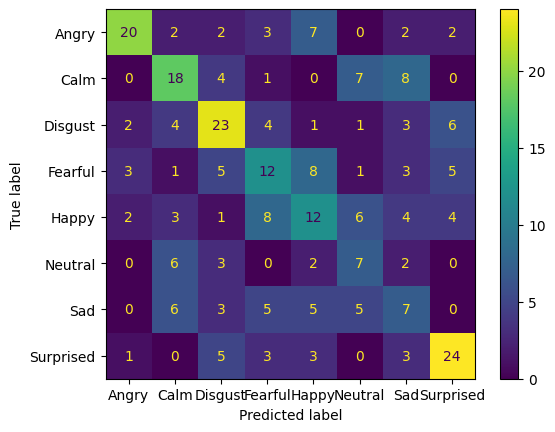

In [ ]:
# Model performance seems OK. If it was guessing randomly would expect accuracy of 0.125.
Confusion_matrix_1 = ConfusionMatrixDisplay.from_predictions(test_y, y_pred_MLP)
plt.show()

# Trying other models

Accuracy low(?) for MLP Classifier, tests for other non-NN models below

In [ ]:
# SVC
SVC_1 = SVC()

SVC_1.fit(training_X_scaled, training_y)
y_pred_SVC = SVC_1.predict(test_X_scaled)
print('SVC: Accuracy = {:.2f}'.format(accuracy_score(test_y, y_pred_SVC)))

SVC: Accuracy = 0.38


In [ ]:
# GradientBoostingClassifier
GBC_1 = GradientBoostingClassifier()

GBC_1.fit(training_X_scaled, training_y)
y_pred_GBC = GBC_1.predict(test_X_scaled)
print('GBC: Accuracy = {:.2f}'.format(accuracy_score(test_y, y_pred_GBC)))

GBC: Accuracy = 0.36


In [ ]:
# LogisticRegression
LR_1 = LogisticRegression()

LR_1.fit(training_X_scaled, training_y)
y_pred_LR = LR_1.predict(test_X_scaled)
print('LR: Accuracy = {:.2f}'.format(accuracy_score(test_y, y_pred_LR)))

LR: Accuracy = 0.38


In [ ]:
# Will stick with the MLP Classifier and try to optimize parameters.
MLP_C.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (300, 250, 150),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
# Attempt at parameter sweep
parameters = {
    "learning_rate_init" : np.arange(0.01,1.01,0.01),
    "hidden_layer_sizes" : [[50,50,50],[100,100,100],[200,200,200],[200,100,50],[300,300,300],[300,200,100],[300,50,50],[500,500,500],[500,300,100]]   ,
    "solver"             : ["lbfgs", "sgd", "adam"],
    "max_iter"           : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
    "momentum"           : np.arange(0.1,1.1,0.1),
    "learning_rate"      : np.arange(0.01,1.01,0.01),
}
param_sweep = GridSearchCV(MLP_C, parameters, scoring="accuracy")
param_sweep.fit(training_X_scaled, training_y)

KeyboardInterrupt: ignored